<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px'>Movie review classification with Scikit Learn.</h1>
</div>

<strong>Content:</strong>

1. Load the Data.
    + Importing Libraries.
    + Loading the data
2. Text Processing.
3. Splitting the data.
4. Building the Classifier.
    + Implementing callbacks
    + Training history
5. Model performance.

The dataset use in this project can be found in this [link](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?select=IMDB+Dataset.csv).
<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Load the Data</h2>
</div>

In this section you will:

- Import the libraries.
- Load the dataset.

### 1.1 Import Libraries

In [1]:
import os
import io
import re

import pandas as pd
import numpy as np

#for data visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#for machine learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

### 1.2 Loading and cleaning the data.

In [2]:
#reading the dataset
df = pd.read_csv("IMDB Dataset.csv")

#cleaning Nan values
df.dropna(inplace = True)

#cleaning reviews which are spaces
spaces = []
for i,rev,label in df.itertuples():
    if rev.isspace():
        spaces.append(i)
        
df.drop(spaces, inplace = True)

#getting labeling count
df["sentiment"].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [3]:
def clean_html(raw_html:str) -> str:
    '''Clean raw html.
    Input:    raw_html    Text with HTML tags
    return:   clean_text  Clean text
    
    '''
    pattern = re.compile('<.*?>')
    clean_text = re.sub(pattern, '', raw_html)
    return clean_text

#cleaning reviews
df["clean_review"] = df["review"].apply(lambda x:clean_html(x))

#labeling 1 for positive 0 for negative
df["labels"] = df["sentiment"].apply(lambda x:1 if x == "positive" else 0)

df.head()

,review,sentiment,clean_review,labels
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...",1


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Text Processing</h2>
</div>

### 2.1 Tokenization

I will transform the text data into tokens, the minimum unit of information (at word level)

In [4]:
#length of the review
maxlen = 100

#to training the model
training_samples = 40000 

#to test the model
validation_samples = 10000 

#The max number of words to keep
max_words = 10000

texts = df["clean_review"]
labels = df["labels"]

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)

In [5]:
#word index
word_index = tokenizer.word_index

#creating sequences.
sequences = tokenizer.texts_to_sequences(texts)

#padding the sequences (maxlen was defined previously, here maxlen =100)
data = pad_sequences(sequences, maxlen=maxlen)

<div class="alert alert-info" style="margin: 20px">Example</div>


In [6]:
#word index revers to maps indexes to words
word_index_reverse = {val:key for key,val in word_index.items()}

for i in range(3):
    print("\n")
    print("Index Sequence:")
    print(data[i])
    print("\n")
    print("Text Sequence:")
    text_sequence = [word_index_reverse[idx] for idx in data[i]]
    print(' '.join(text_sequence))



Index Sequence:
[ 122  209 3237   67   13   33 1635    8   12 2242    9  412  130    9
   12 1591   14    8   17   13    9  286   50    9 1415    3 1279   14
 3182    2  188    5    1  297 2042    4 2149  569   20   38  569   17
 7655 7151 5006   25 2981   41   14    3 6898  503   19  641    2   75
  242   15    8   68 7596  650  709 6898  108  662   81 1207  692    5
   64  573    4  917 2019   37 1207  558  146 3182   21  199  425 3816
   15   47    6 3310  802 1600   42   21   66   75    7 1226   15  124
 4102  485]


Text Sequence:
ever saw struck me as so nasty it was surreal i couldn't say i was ready for it but as i watched more i developed a taste for oz and got to the high levels of graphic violence not just violence but injustice crooked guards be sold out for a inmates kill on order and get away with it well mannered middle class inmates being turned into prison due to their lack of street skills or prison experience watching oz you may become comfortable with what is unco

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3. Splitting the data</h2>
</div>

In [7]:
#we need random indexing to avoid biased learning
index = np.arange(data.shape[0])
np.random.shuffle(index)
data = data[index]
labels = labels[index]

#creating the training and 
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Building the classifier.</h2>
</div>

In [8]:
#Embedding dimension
embedding_dim = 64


#building the model
model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(GlobalAveragePooling1D())
model.add(Dense(6,activation = "relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="rmsprop",loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 640,397
Trainable params: 640,397
Non-trainable params: 0
_________________________________________________________________


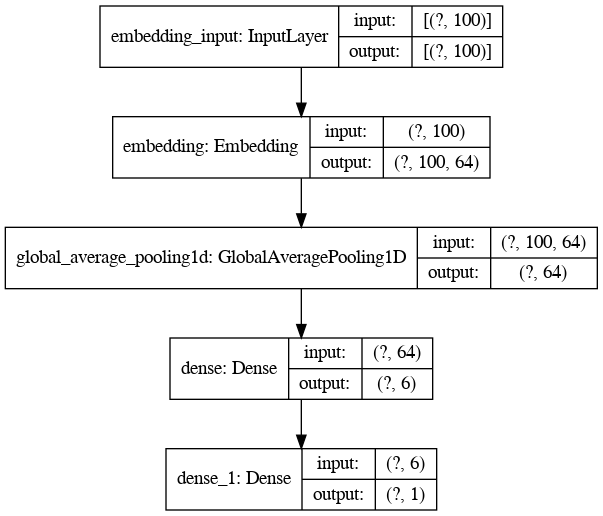

In [9]:
#plotting the model architecture
plot_model(model, show_shapes=True)

### Implementing callbacks

Let's use stop early to avoid overfitting and reduce lr to improve the learning process

In [10]:
# callbacks

#implementing early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4,
                                              restore_best_weights=True)

#reduceOnplateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                  patience=2, min_lr=0.0001)

#fitting the model
history = model.fit(x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data = (x_val,y_val),
    callbacks = [early_stop,reduce_lr]
)

Epoch 1/100
1250/1250 [==============================] - 15s 12ms/step - loss: 0.4330 - acc: 0.8160 - val_loss: 0.3198 - val_acc: 0.8616 - lr: 0.0010
Epoch 2/100
1250/1250 [==============================] - 12s 9ms/step - loss: 0.2878 - acc: 0.8777 - val_loss: 0.3131 - val_acc: 0.8672 - lr: 0.0010
Epoch 3/100
1250/1250 [==============================] - 13s 11ms/step - loss: 0.2656 - acc: 0.8895 - val_loss: 0.3102 - val_acc: 0.8680 - lr: 0.0010
Epoch 4/100
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2545 - acc: 0.8945 - val_loss: 0.3142 - val_acc: 0.8679 - lr: 0.0010
Epoch 5/100
1250/1250 [==============================] - 11s 8ms/step - loss: 0.2472 - acc: 0.8989 - val_loss: 0.3172 - val_acc: 0.8694 - lr: 0.0010
Epoch 6/100
1250/1250 [==============================] - 12s 10ms/step - loss: 0.2317 - acc: 0.9069 - val_loss: 0.3193 - val_acc: 0.8686 - lr: 2.0000e-04
Epoch 7/100
1250/1250 [==============================] - 14s 12ms/step - loss: 0.2305 - acc: 0.907

In [11]:
#saving the model.
model.save("movie_review_classifier.h5")

### 4.2 Training history

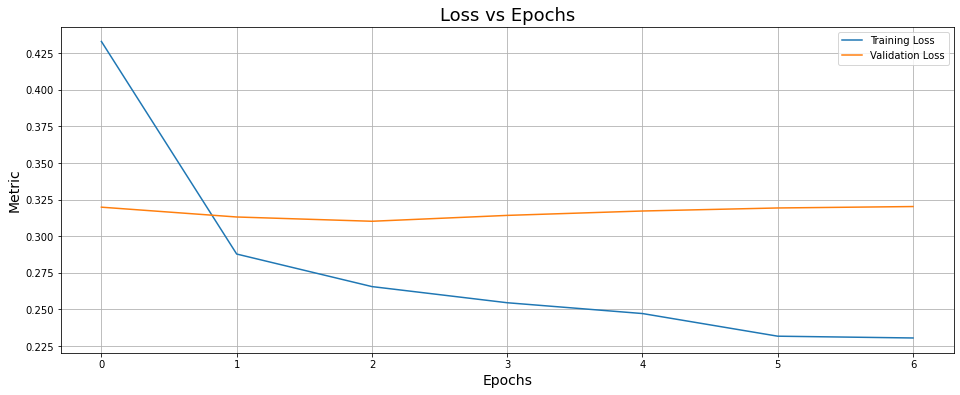

In [12]:
plt.figure(figsize=(16,6))
plt.plot(history.history["loss"], label ="Training Loss")
plt.plot(history.history["val_loss"],label ="Validation Loss")
plt.legend(loc="best")
plt.title("Loss vs Epochs",fontsize = 18)
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Metric", fontsize = 14)
plt.grid()

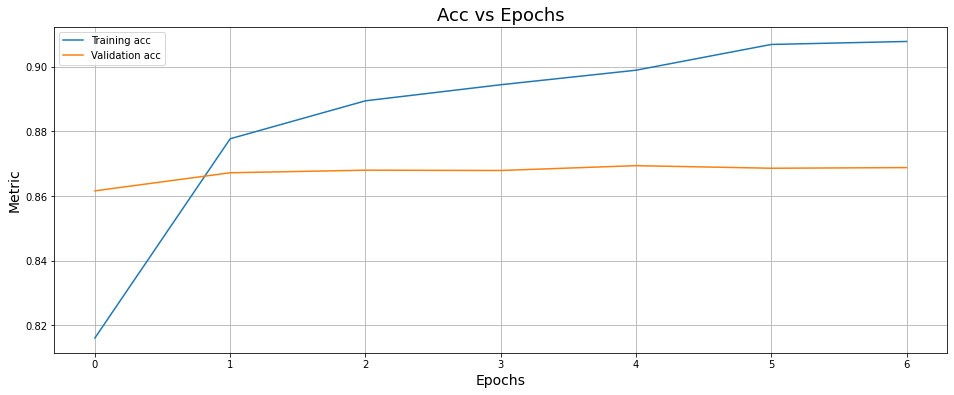

In [13]:
plt.figure(figsize=(16,6))
plt.plot(history.history["acc"], label ="Training acc")
plt.plot(history.history["val_acc"], label ="Validation acc")
plt.legend(loc="best")
plt.title("Acc vs Epochs",fontsize = 18)
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Metric", fontsize = 14)
plt.grid()

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>5. Model Performance</h2>
</div>

In [14]:
#general performance
performance_on_test_data = model.evaluate(x_val,y_val)

print(f"Loss: {performance_on_test_data[0]} Accuracy: {performance_on_test_data[1]*100} %")

313/313 [==============================] - 1s 3ms/step - loss: 0.3102 - acc: 0.8680
Loss: 0.31017005443573 Accuracy: 86.79999709129333 %


In [15]:
#get the predictions
predictions = model.predict(x_val)
predictions = [1 if p >=0.5 else 0 for p in predictions]

#confusion matrix
confusion_matrix(predictions, y_val)

array([[4359,  621],
       [ 699, 4321]])

In [16]:
print(classification_report(predictions,y_val))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4980
           1       0.87      0.86      0.87      5020

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## visualizing word embeddings

In [17]:
#getting the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 64)


In [18]:
#generating the files to use in embedding projector
out_v = io.open("vecs.tsv",'w',encoding = 'utf-8')
out_m = io.open("meta.tsv",'w',encoding = 'utf-8')

for word_num in range(1,max_words):
    word = word_index_reverse[word_num]
    embeddings = weights[word_num]
    out_m.write(word+"\n")
    out_v.write('\t'.join([str(x) for x in embeddings])+"\n")
    
out_v.close()
out_m.close()